In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix

Epoch 1/50
56/56 [==============================] - 0s 3ms/step - loss: 0.0471 - val_loss: 0.0342
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0224
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0191 - val_loss: 0.0165
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0144 - val_loss: 0.0129
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0109
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0091 - val_loss: 0.0089
Epoch 8/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0082
Epoch 9/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 10/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 11/50
56/56 [

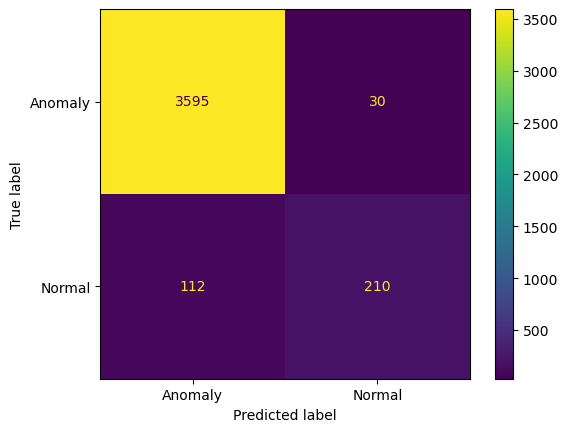

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def hybrid_anomaly_detection():
    # Load data from a CSV file
    data = pd.read_csv('energydata.csv')
    
    data = data.drop('date', axis=1)
    
    X = data.drop('Windspeed', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['Windspeed']
    
    #convert all the values in the columns into numeric
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')

    data.dropna(axis=0, inplace=True)
    
#     #Scatter plot
#     sns.pairplot(data, kind='scatter')
#     plt.title('Scatter Plot')
#     plt.show()
    
    
    y = np.where(y_cont > 8, 1, 0)  # Define `threshold` based on the dataset
    
        
    # Select top k features; you might adjust k based on your dataset
    selector = SelectKBest(f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    
    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Define and train the autoencoder
    input_dim = X_train.shape[1]
    encoding_dim = 32
    input_layer = tf.keras.Input(shape=(input_dim,))
    encoded = layers.Dense(encoding_dim, activation='relu', 
                           activity_regularizer=regularizers.l1(10e-5))(input_layer)
    decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = models.Model(input_layer, decoded)
    encoder = models.Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_split=0.1, verbose=1)

    # Encode the data
    X_train_encoded = encoder.predict(X_train)
    X_test_encoded = encoder.predict(X_test)
    
    # Train Isolation Forest on the encoded data
    iso_forest = IsolationForest(random_state=42)
    iso_forest.fit(X_train_encoded)
    if_train_labels = iso_forest.predict(X_train_encoded)
    
    # Filter data where Isolation Forest predicts normal
    normal_indices = if_train_labels == 1
    X_train_normal = X_train_encoded[normal_indices]
    y_train_normal = y_train[normal_indices]
    
    # Train XGBoost on the filtered normal data
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgb.fit(X_train_normal, y_train_normal)
    
    # Predict on the entire test dataset with XGBoost
    xgb_predictions = xgb.predict(X_test_encoded)
    
    # Evaluate the model
    precision = precision_score(y_test, xgb_predictions, pos_label=1)
    recall = recall_score(y_test, xgb_predictions, pos_label=1)
    f1 = f1_score(y_test, xgb_predictions, pos_label=1)
    
    
    print(classification_report(y_test, xgb_predictions))
    
    # Print metrics
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    
    # Display the confusion matrix
    cm = confusion_matrix(y_test, xgb_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()

# Example usage
hybrid_anomaly_detection()


Epoch 1/50
56/56 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0354
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0257
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0197
Epoch 4/50
56/56 [==============================] - 0s 3ms/step - loss: 0.0174 - val_loss: 0.0157
Epoch 5/50
56/56 [==============================] - 0s 3ms/step - loss: 0.0141 - val_loss: 0.0129
Epoch 6/50
56/56 [==============================] - 0s 4ms/step - loss: 0.0117 - val_loss: 0.0110
Epoch 7/50
56/56 [==============================] - 0s 3ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 8/50
56/56 [==============================] - 0s 3ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 9/50
56/56 [==============================] - 0s 3ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 10/50
56/56 [==============================] - 0s 3ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 11/50
56/56 [

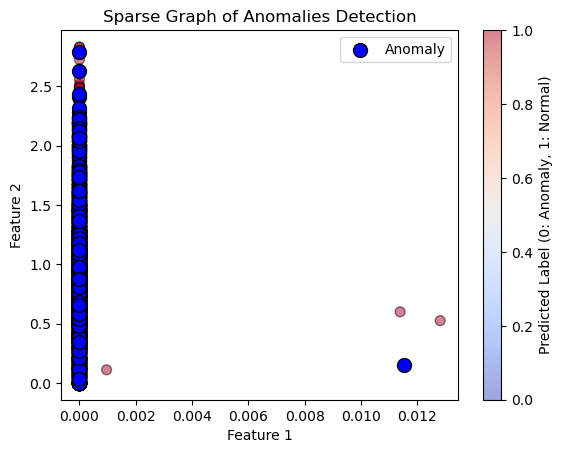

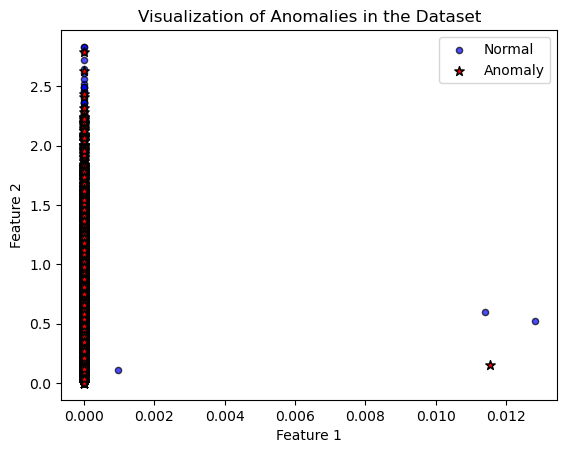

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def complete_anomaly_detection_system():
    data = pd.read_csv('energydata.csv')
    
    data = data.drop('date', axis=1)
    
    X = data.drop('Windspeed', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['Windspeed']
    
    #convert all the values in the columns into numeric
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')

    data.dropna(axis=0, inplace=True)
    
#     #Scatter plot
#     sns.pairplot(data, kind='scatter')
#     plt.title('Scatter Plot')
#     plt.show()
    
    
    y = np.where(y_cont > 3, 1, 0)  # Define `threshold` based on the dataset
    
        
    # Select top k features; you might adjust k based on your dataset
    selector = SelectKBest(f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    
    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    input_dim = X_train.shape[1]
    encoding_dim = 32
    input_layer = tf.keras.Input(shape=(input_dim,))
    encoded = layers.Dense(encoding_dim, activation='relu', 
                           activity_regularizer=regularizers.l1(10e-5))(input_layer)
    decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = models.Model(input_layer, decoded)
    encoder = models.Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_split=0.1, verbose=1)

    X_train_encoded = encoder.predict(X_train)
    X_test_encoded = encoder.predict(X_test)
    
    iso_forest = IsolationForest(random_state=42)
    iso_forest.fit(X_train_encoded)
    if_train_labels = iso_forest.predict(X_train_encoded)
    
    normal_indices = if_train_labels == 1
    X_train_normal = X_train_encoded[normal_indices]
    y_train_normal = y_train[normal_indices]
    
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgb.fit(X_train_normal, y_train_normal)
    
    xgb_predictions = xgb.predict(X_test_encoded)
    
    # Plotting the results
    plot_sparse_graph(X_test_encoded, y_test, xgb_predictions)

def plot_sparse_graph(X, y, predictions):
    fig, ax = plt.subplots()
    scatter = ax.scatter(X[:, 0], X[:, 1], c=predictions, cmap='coolwarm', edgecolor='k', s=50, alpha=0.5)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Predicted Label (0: Anomaly, 1: Normal)')
    
    anomalies = X[predictions == 0]
    ax.scatter(anomalies[:, 0], anomalies[:, 1], color='blue', label='Anomaly', edgecolor='k', s=100)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title('Sparse Graph of Anomalies Detection')
    ax.legend()
    
    plt.show()
    
    
    fig, ax = plt.subplots()
    # Plot normal points with a default color
    normal = X[predictions == 1]  # Assuming '1' is the label for normal
    anomalies = X[predictions == 0]  # Assuming '0' is the label for anomalies

    # Scatter plot for normal points
    ax.scatter(normal[:, 0], normal[:, 1], c='blue', label='Normal', edgecolor='k', s=20, alpha=0.7)

    # Scatter plot for anomalies
    ax.scatter(anomalies[:, 0], anomalies[:, 1], c='red', label='Anomaly', edgecolor='black', s=50, marker='*')

    # Additional plot settings
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title('Visualization of Anomalies in the Dataset')
    ax.legend(loc='upper right')
    
    plt.show()
    
    
    

# Example usage
complete_anomaly_detection_system()
